In [1]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable

keras.utils.set_random_seed(0)
if len(tf.config.list_physical_devices("GPU")) == 0:
    raise RuntimeError("No GPU found")

# Hyperparameters

In [2]:
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 1
EPOCHS = 30
LEARNING_RATE = 2e-4
LAMBDA = 5.0

ACTIVATION = keras.activations.swish
GEN_DEPTH = 6      # generator UNET depth
GEN_FILTERS = 32   # generator UNET filter size
DISCR_DEPTH = 3    # discriminator depth
DISCR_FILTERS = 16 # discriminator filter size

# Data preparation

256x256 images, pixel values are normalized to $[-1, 1]$.

In [3]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.clip_by_value(tf.cast(image, tf.float32) * 2.0 / 255.0 - 1.0, -1.0, 1.0)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image


def reverse_transform(image):
    transformed = tf.clip_by_value((image + 1.0) / 2.0 * 255.0, 0.0, 255.0)
    return transformed.numpy().astype(np.uint8)


def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    return image


def load_dataset(filenames, batch_size=BATCH_SIZE):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

## Load datasets

In [4]:
MONET_FILENAMES = tf.io.gfile.glob("data/monet_tfrec/*.tfrec")
monet_ds = load_dataset(MONET_FILENAMES)

PHOTO_FILENAMES = tf.io.gfile.glob("data/photo_tfrec/*.tfrec")
photo_ds = load_dataset(PHOTO_FILENAMES)

## Data visualization

In [5]:
def plot(imgs, cols=5, title=None, filename=None):
    rows = int(np.ceil(1.0 * sum(1 for _ in imgs) / cols))
    plt.figure(figsize=(2 * cols, 2 * rows))
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(tf.squeeze(reverse_transform(img)))
        plt.axis("off")

    plt.tight_layout()
    if title is not None:
        _, h = plt.gcf().get_size_inches()
        plt.suptitle(title, y=(1 + 0.1 / h))
    if filename is None:
        filename = round(tf.timestamp().numpy())
    plt.savefig(f"output/{filename}.png")
    plt.show()

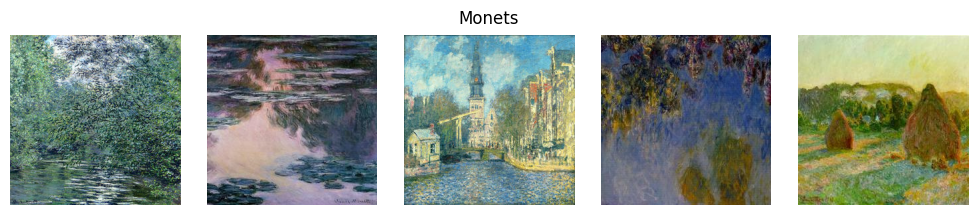

In [6]:
plot(monet_ds.take(5), title="Monets", filename="example_monets")

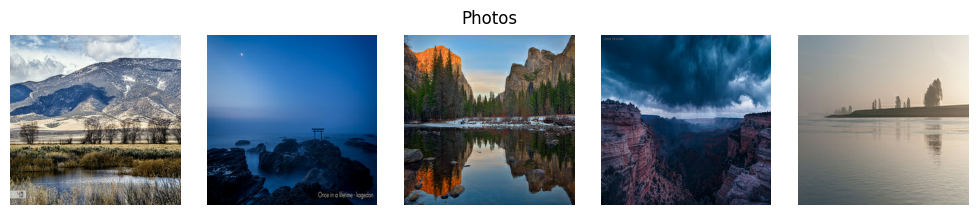

In [7]:
plot(photo_ds.take(5), title="Photos", filename="example_photos")

# Models

Our implementation utilizes a CycleGAN model. [CycleGAN](https://arxiv.org/abs/1703.10593) extends the capability of GANs to transform between domains without unpaired examples. This is achieved by introducing another generator-discriminator pair to the network, which carry out the inverse transformation. The addition forces the network to preserve some information from the original domain during transformation, so that it can inverse transform back to the original domain, and not just generate a random image in the other domain. The architecture of a CycleGAN is presented below.

![CycleGAN architecture](doc/architecture.png)


In our case, the parts of CycleGAN correspond to:
- domain $X$: photos
- domain $Y$: Monet paintings
- generator $F$: transforms photos to Monet paintings
- generator $G$: transforms Monet paintings to photos
- discriminator $D_X$: tells real and fake photos apart
- discriminator $D_Y$: tells real and fake Monet paintings apart

## Generator

The generators of our model are [UNET](http://arxiv.org/abs/1505.04597)s. First it downsamples the input to a lower resolution image, then it is upsampled back to its original size, creating skip connections between layers at the same depth.

![UNET architecture](doc/unet.jpg)

We apply instance normalization after down- and upsampling.

In [8]:
def create_u_net(depth: int, filters: int, activation) -> Callable[[tf.Tensor], tf.Tensor]:

    # residual block with 4 convolutional layers and instance normalization
    def residual_block(depth: int, filters: int) -> Callable[[tf.Tensor], tf.Tensor]:
        def apply(x: tf.Tensor) -> tf.Tensor:
            # downsampling
            x = keras.layers.Conv2D(
                filters,
                (3, 3),
                activation=activation,
                padding="same",
            )(x)
            x = keras.layers.Conv2D(
                filters,
                (3, 3),
                activation=activation,
                padding="same",
            )(x)

            # instance normalization
            x = keras.layers.BatchNormalization(
                axis=3,
            )(x)
            x = activation(x)

            # return or maxpool for next level
            if depth == 0:
                return x
            y = keras.layers.MaxPooling2D((2, 2))(x)
            nextFilters = min(filters * 2, 512)

            # get output of next layer recursively
            y = residual_block(depth=depth - 1, filters=nextFilters)(y)

            # halve the number of channels
            y = keras.layers.UpSampling2D((2, 2))(y)
            y = keras.layers.Conv2D(
                filters,
                (1, 1),
            )(y)

            # skip connection
            x = keras.layers.add([x, y])

            # upsampling
            x = keras.layers.Conv2D(
                filters,
                (3, 3),
                activation=activation,
                padding="same",
            )(x)
            x = keras.layers.Conv2D(
                filters,
                (3, 3),
                activation=activation,
                padding="same",
            )(x)

            # instance normalization
            x = keras.layers.BatchNormalization(
                axis=3,
            )(x)
            x = activation(x)

            return x

        return apply

    def apply(x: tf.Tensor) -> tf.Tensor:
        residual_blocks = residual_block(depth=depth, filters=filters)(x)
        output_layer = keras.layers.Conv2D(
            3,
            (1, 1),
            kernel_initializer="zeros",
        )(residual_blocks)
        return output_layer

    return apply

In [9]:
def create_generator(depth=GEN_DEPTH, filters=GEN_FILTERS, activation=ACTIVATION) -> keras.Model:
    input_layer = keras.layers.Input(shape=[*IMAGE_SIZE, 3])
    output_layer = create_u_net(depth=depth, filters=filters, activation=activation)(input_layer)
    return keras.Model(inputs=[input_layer], outputs=[output_layer])

## Discriminator

The discriminators of our model downsample the input to a lower resolution image, followed by instance normalization, after which a dense layer produces the single verdict of the discriminator about the image's authenticity.

In [10]:
def create_discriminator(depth=DISCR_DEPTH, filters=DISCR_FILTERS, activation=ACTIVATION) -> keras.Model:
    input_layer = keras.layers.Input(shape=[*IMAGE_SIZE, 3])
    x = input_layer

    # downsampling
    for _ in range(depth):
        x = keras.layers.Conv2D(
            filters,
            (3, 3),
            activation=activation,
            padding="same",
        )(x)
        x = keras.layers.Conv2D(
            filters,
            (3, 3),
            activation=activation,
            padding="same",
        )(x)
        x = keras.layers.MaxPooling2D((2, 2))(x)

    # instance normalization
    x = keras.layers.BatchNormalization(axis=3)(x)
    x = activation(x)

    # generating verdict
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1)(x)
    return keras.Model(inputs=[input_layer], outputs=[x])

## CycleGAN

The model is built from the generators and discriminators as described above. It takes the photo - Monet painting pair $(x_{real}, y_{real})$ and applies the following transformations during training:

### 1. Forward

The real photo $x_{real}$ is fed to $F$, which transforms it into a fake Monet painting $y_{fake}$. The painting discriminator $D_Y$ receives $y_{fake}$ and $y_{real}$, classifies them resulting in the loss $L_Y$ that is used to train both $F$ and $D_Y$, just like a regular GAN. Unlike a regular GAN, the fake Monet painting $y_{fake}$ is transformed back to a photo $x_{cycled}$ by $G$, so that the difference $L_{cycle}$ between the original and cycled photo can be used to train both generators, in order to improve their ability to actually transform between the 2 domains and not just generate new instances in each.

![CycleGAN forward](doc/forward.png)

### 2. Backward

The real Monet painting $y_{real}$ is fed to $G$, which transforms it into a fake photo $x_{fake}$. The photo discriminator $D_X$ receives $x_{fake}$ and $x_{real}$, classifies them resulting in the loss $L_X$ that is used to train both $G$ and $D_X$, just like a regular GAN. Unlike a regular GAN, the fake photo $x_{fake}$ is transformed back to a Monet painting $y_{cycled}$ by $F$, so that the difference $L_{cycle}$ between the original and cycled Monet painting can be used to train both generators, in order to improve their ability to actually transform between the 2 domains and not just generate new instances in each.

![CycleGAN backward](doc/backward.png)

### 3. Identity

Additionally, to help the generators identify features of the domains, they are also fed images from the target domain and are trained based on how well they return the same image. For example, $F$ is given the Monet painting $y_{real}$ and is trained based on $L_{identity}$, that is, how similar its output $y_{identity}$ is to $y_{real}$.

![CycleGAN identity](doc/identity.png)

After all of the transformations above are applied, the losses are calculated and applied in the following way, weighted by the hyperparameter $\lambda$:
- generator $F$: $L_Y + \lambda * L_{cycle} + \frac{\lambda}{2} * L_{identity}$
- generator $G$: $L_X + \lambda * L_{cycle} + \frac{\lambda}{2} * L_{identity}$
- discriminator $D_X$: $L_X$
- discriminator $D_Y$: $L_Y$

The hyperparameter $\lambda$ can be used to amplify/reduce the significance of creating a mapping between instances in the two domains, as opposed to the actual style transfer.

In [11]:
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(keras.losses.mean_squared_error(y_true, y_pred))

In [12]:
@keras.saving.register_keras_serializable()
class CycleGan(keras.Model):
    def __init__(
        self,
        f: keras.Model,
        g: keras.Model,
        dx: keras.Model,
        dy: keras.Model,
        lambda_: float,
    ):
        super(CycleGan, self).__init__(name='cyclegan')
        self.f = f             # Monet -> photo generator
        self.g = g             # photo -> Monet generator
        self.dx = dx           # photo discriminator
        self.dy = dy           # Monet discriminator
        self.lambda_ = lambda_ # cycle and identity loss weight

    def compile(self, learning_rate=LEARNING_RATE):
        super().compile()
        self.f_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.g_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.dx_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.dy_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    def call(self, data, training=None):
        real_x, real_y = data

        fake_y = self.f(real_x, training=training)
        fake_x = self.g(real_y, training=training)
        cycled_x = self.g(fake_y, training=training)
        cycled_y = self.f(fake_x, training=training)
        same_x = self.g(real_x, training=training)
        same_y = self.f(real_y, training=training)

        disc_real_x = self.dx(real_x, training=training)
        disc_real_y = self.dy(real_y, training=training)
        disc_fake_x = self.dx(fake_x, training=training)
        disc_fake_y = self.dy(fake_y, training=training)

        return fake_x, fake_y, cycled_x, cycled_y, same_x, same_y, disc_real_x, disc_real_y, disc_fake_x, disc_fake_y

    def train_step(self, data):
        real_x, real_y = data
        with tf.GradientTape(persistent=True) as tape:
            fake_x, fake_y, cycled_x, cycled_y, same_x, same_y, disc_real_x, disc_real_y, disc_fake_x, disc_fake_y = self(data, training=True)

            cycle_loss = mse_loss(real_x, cycled_x) + mse_loss(real_y, cycled_y)
            gen_f_loss = (
                keras.losses.binary_crossentropy(tf.ones_like(disc_fake_y), disc_fake_y)    # discriminator loss
                + self.lambda_ * cycle_loss                                                 # cycle loss
                + self.lambda_ * 0.5 * mse_loss(real_y, same_y)                             # identity loss
            )
            gen_g_loss = (
                keras.losses.binary_crossentropy(tf.ones_like(disc_fake_x), disc_fake_x)    # discriminator loss
                + self.lambda_ * cycle_loss                                                 # cycle loss
                + self.lambda_ * 0.5 * mse_loss(real_x, same_x)                             # identity loss
            )
            disc_x_loss = 0.5 * (
                keras.losses.binary_crossentropy(tf.ones_like(disc_real_x), disc_real_x)    # original detection
                + keras.losses.binary_crossentropy(tf.zeros_like(disc_fake_x), disc_fake_x) # fake detection
            )
            disc_y_loss = 0.5 * (
                keras.losses.binary_crossentropy(tf.ones_like(disc_real_y), disc_real_y)    # original detection
                + keras.losses.binary_crossentropy(tf.zeros_like(disc_fake_y), disc_fake_y) # fake detection
            )

        grad_f = tape.gradient(gen_f_loss, self.f.trainable_variables)
        grad_g = tape.gradient(gen_g_loss, self.g.trainable_variables)
        grad_dx = tape.gradient(disc_x_loss, self.dx.trainable_variables)
        grad_dy = tape.gradient(disc_y_loss, self.dy.trainable_variables)

        self.f_optimizer.apply_gradients(zip(grad_f, self.f.trainable_variables))
        self.g_optimizer.apply_gradients(zip(grad_g, self.g.trainable_variables))
        self.dx_optimizer.apply_gradients(zip(grad_dx, self.dx.trainable_variables))
        self.dy_optimizer.apply_gradients(zip(grad_dy, self.dy.trainable_variables))

        return {
            "gen_f_loss": gen_f_loss,
            "gen_g_loss": gen_g_loss,
            "disc_x_loss": disc_x_loss,
            "disc_y_loss": disc_y_loss,
        }

    def get_config(self):
        config = super().get_config()
        config['f'] = self.f.get_config()
        config['g'] = self.g.get_config()
        config['dx'] = self.dx.get_config()
        config['dy'] = self.dy.get_config()
        config['lambda_'] = self.lambda_
        return config

    @classmethod
    def from_config(cls, config):
        f = keras.Model.from_config(config['f'])
        g = keras.Model.from_config(config['g'])
        dx = keras.Model.from_config(config['dx'])
        dy = keras.Model.from_config(config['dy'])
        lambda_ = config['lambda_']
        return cls(f, g, dx, dy, lambda_)

# Training

In [13]:
F = create_generator()
G = create_generator()
DX = create_discriminator()
DY = create_discriminator()
model = CycleGan(F, G, DX, DY, lambda_=LAMBDA)
model.compile()

In [14]:
# checkpoint for storing best model according to F (photo -> monet) loss
best_loss_model_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="output/best_f_loss.keras",
    monitor="gen_f_loss",
    save_best_only=True,
    mode="min",
)

# TODO checkpoint for storing best model according to MiFID
# best_mifid_model_cb = tf.keras.callbacks.ModelCheckpoint(
#     filepath="output/unet_mifid.h5",
#     monitor="val_mifid",
#     save_best_only=True,
#     save_weights_only=True,
#     mode="min",
# )

In [15]:
history = model.fit(
    tf.data.Dataset.zip((photo_ds, monet_ds)),
    epochs=EPOCHS,
    callbacks=[best_loss_model_cb],
)

Epoch 1/30
300/300 [==============================] - 172s 391ms/step - gen_f_loss: 6.0451 - gen_g_loss: 5.0787 - disc_x_loss: 1.2985 - disc_y_loss: 1.6940
Epoch 2/30
300/300 [==============================] - 154s 513ms/step - gen_f_loss: 2.5329 - gen_g_loss: 2.5766 - disc_x_loss: 0.6931 - disc_y_loss: 0.5718
Epoch 3/30
300/300 [==============================] - 145s 484ms/step - gen_f_loss: 2.3594 - gen_g_loss: 2.2878 - disc_x_loss: 0.7266 - disc_y_loss: 0.6113
Epoch 4/30
300/300 [==============================] - 145s 482ms/step - gen_f_loss: 2.2815 - gen_g_loss: 2.2370 - disc_x_loss: 0.6784 - disc_y_loss: 0.7236
Epoch 5/30
300/300 [==============================] - 145s 482ms/step - gen_f_loss: 2.0986 - gen_g_loss: 2.0225 - disc_x_loss: 0.7047 - disc_y_loss: 0.6325
Epoch 6/30
300/300 [==============================] - 94s 314ms/step - gen_f_loss: 1.8742 - gen_g_loss: 1.8076 - disc_x_loss: 0.7420 - disc_y_loss: 0.7288
Epoch 7/30
300/300 [==============================] - 94s 314ms/s

In [16]:
model.save("output/last_model.keras")

# Evaluation

## Loss

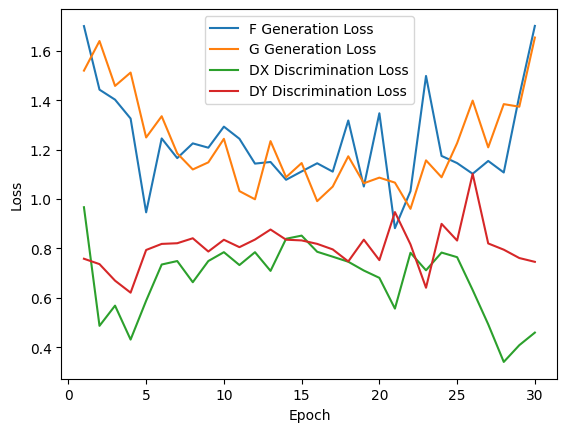

In [17]:
# plot training and validation loss
ticks = range(1, len(history.history["gen_f_loss"]) + 1)
plt.plot(ticks, history.history["gen_f_loss"], label="F Generation Loss")
plt.plot(ticks, history.history["gen_g_loss"], label="G Generation Loss")
plt.plot(ticks, history.history["disc_x_loss"], label="DX Discrimination Loss")
plt.plot(ticks, history.history["disc_y_loss"], label="DY Discrimination Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("output/losses.png")
plt.show()

# Demo

In [18]:
best_model = keras.models.load_model("output/best_f_loss.keras", custom_objects={"CycleGan": CycleGan})
best_model.compile()

In [19]:
def demo_transformations(model, img_count=1):
    imgs = []
    for photo in photo_ds.take(img_count):
        fake_monet = model.f(photo, training=False)
        cycled_photo = model.g(fake_monet, training=False)
        imgs += [photo, fake_monet, cycled_photo]
    plot(imgs, cols=3, title="Photo -> Monet -> Photo", filename="demo_f")

    imgs = []
    for monet in monet_ds.take(img_count):
        fake_photo = model.g(monet, training=False)
        cycled_monet = model.f(fake_photo, training=False)
        imgs += [monet, fake_photo, cycled_monet]
    plot(imgs, cols=3, title="Monet -> Photo -> Monet", filename="demo_g")

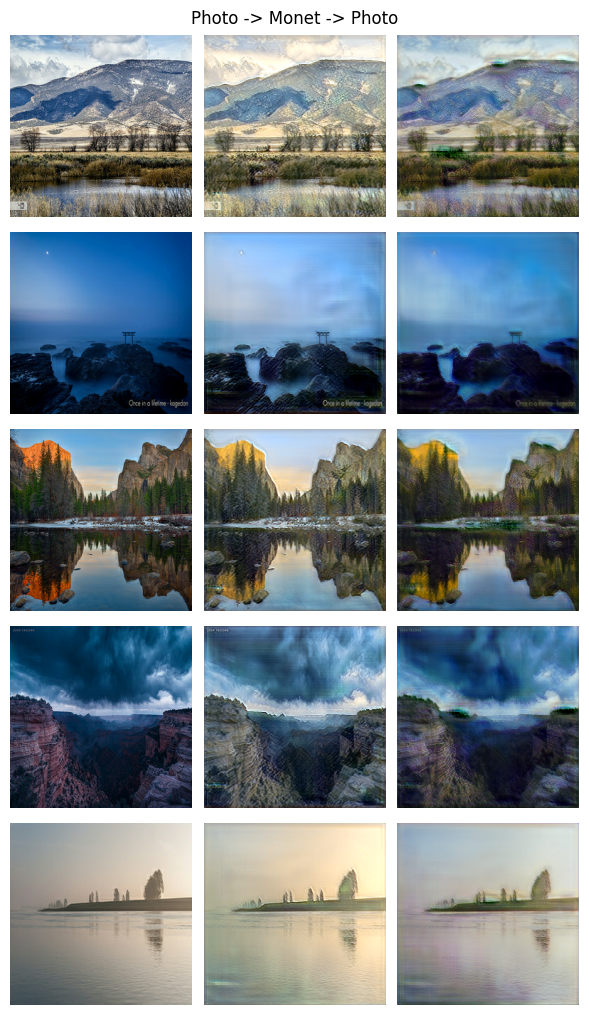

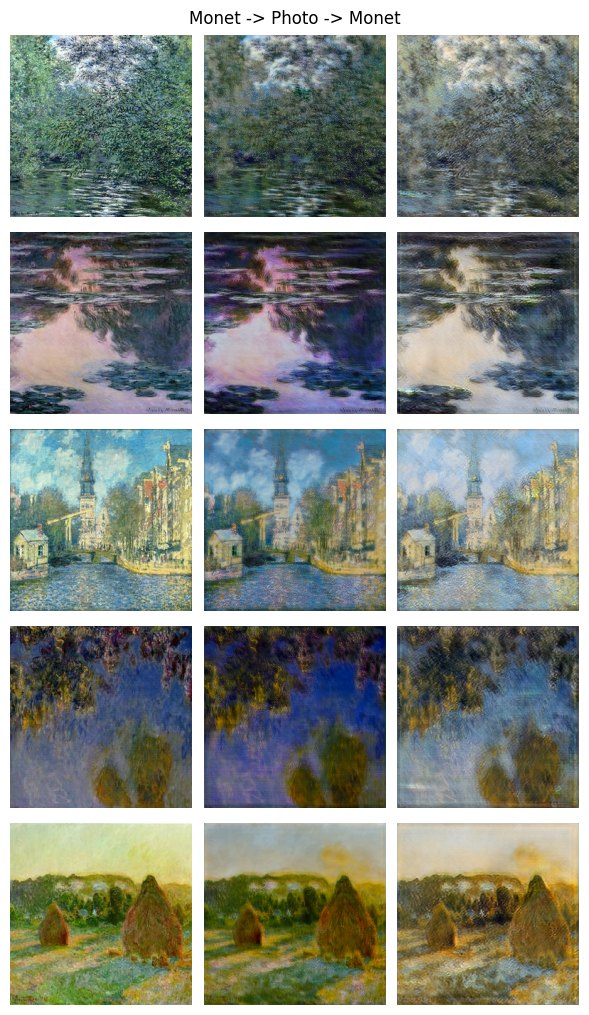

In [20]:
demo_transformations(best_model, 5)